In [27]:
from itertools import islice

import networkx as nx
import numpy as np
import pandas as pd

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "dpdf"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.dataset = "pmart"
args.pattern_dataset = "dpdf"
#args.pattern_dataset = "CPG_pmart"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/dpdf_undirected_anchored_v2/model.pt ...


In [4]:
"""
pattern_types = [
    cpg_const.DesignPatternType.BUILDER.value,
    cpg_const.DesignPatternType.DECORATOR.value ]
"""
pattern_types = None
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False, pattern_types=pattern_types )
up_sources = dataset.get_sources()
up_patterns = dataset.get_patterns()

Loading sources from pmart ...


100%|██████████| 1262/1262 [00:00<00:00, 3243.07it/s]


Loading sources from dpdf ...


100%|██████████| 7469/7469 [00:02<00:00, 2546.16it/s]


In [5]:
p_sources = up_sources
p_sources = epm.filter_sources( p_sources, dataset.get_source_patterns(), max_sources_per_pattern=10 )
p_sources = epm.normalize_sources( p_sources, max_distance=6 )

p_patterns = up_patterns
#p_patterns = epm.normalize_patterns( p_patterns, max_distance=8 )
p_patterns = epm.get_common_patterns( p_patterns, max_node_distance=5 )
"""
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=20, n_decay=4 )
"""
"""
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=30, n_decay=2 )
"""
dataset.set_sources( p_sources )
dataset.set_patterns( p_patterns )
dataset.compute_samples()
epm.print_pattern_counts( dataset )

Filtering sources ...


100%|██████████| 1262/1262 [00:00<00:00, 3701546.61it/s]


Normalizing sources ...


100%|██████████| 75/75 [00:02<00:00, 34.43it/s] 


Normalize patterns ...


100%|██████████| 12/12 [00:00<00:00, 12.77it/s]


Compute common patterns for SINGLETON ...
Size after iter 0: 2
Compute common patterns for FACTORY_METHOD ...
Size after iter 0: 13
Size after iter 1: 6
Size after iter 2: 2
Compute common patterns for ABSTRACT_FACTORY ...
Size after iter 0: 13
Size after iter 1: 6
Size after iter 2: 3
Compute common patterns for ADAPTER ...
Size after iter 0: 0
Compute common patterns for FACADE ...
Size after iter 0: 4
Compute common patterns for OBSERVER ...
Size after iter 0: 9
Size after iter 1: 5
Compute common patterns for PROXY ...
Size after iter 0: 3
Compute common patterns for VISITOR ...
Size after iter 0: 26
Size after iter 1: 14
Size after iter 2: 6
Size after iter 3: 1
Compute common patterns for BUILDER ...
Size after iter 0: 9
Size after iter 1: 6
Size after iter 2: 4
Compute common patterns for PROTOTYPE ...
Size after iter 0: 7
Size after iter 1: 3
Compute common patterns for DECORATOR ...
Size after iter 0: 6
Size after iter 1: 5
Compute common patterns for MEMENTO ...
source_patter

In [6]:
def sample_processor_path_match_weighted( source: nx.Graph, query: nx.Graph, meta: dict ) -> tuple[ list, list, list ]:
    source_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( source ) ] )
    query_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( query ) ] )
    max_match = 0
    for sp in source_paths:
        for qp in query_paths:
            for k in list( range( 1, min( len( sp ), len( qp ) ) + 1 ) ):
                qpk = qp[ :k ]
                if sp.startswith( qpk ) and len( qpk ) > max_match:
                    max_match = len( qpk )

    pred_w = max_match / max( [ len( p ) for p in source_paths ] )
    _meta = meta.copy()
    _meta[ "pred_w" ] = pred_w
    return epm.sample_processor_default( source, query, _meta )

In [7]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                #sample_processor=epm.sample_processor_subgraph_normalized,
                                                sample_processor=epm.sample_processor_k_normalized,
                                                min_d_offset=1, max_d_offset=5,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]

source: 4162 / queries: 4162
preds: 4162 / metas: 4162
meta example: {'source_type': 'N/A', 'pattern_type': 'SINGLETON', 'gidx': 394, 'record_scope': 'test.net.sourceforge.pmd.cpd.JavaTokensTokenizerTest', 'record_dataset': 'p_mart-11_-_pmd_v18', 'pred_w': 0.2}


In [8]:
def aggregate_preds_max( preds: list[ float ] ) -> float:
    return float( np.max( preds ) )

In [10]:
groups_by_source = epm.group_by_source( metas )
source_preds = epm.compute_source_preds( groups_by_source, preds, metas,
                                         #pred_aggregator=aggregate_preds_max )
                                         pred_aggregator=epm.aggregate_preds_by_quantile, q=0.99 )
source_types = epm.compute_source_types( metas )
#true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds, conf=0.5, top_k=1 )
true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds, conf=0.2 )

for k, v in islice( source_types.items(), 3 ):
    print( f"type::{k}={source_types[ k ]}" )
    print( f"group::{k}={groups_by_source[ k ]}" )
    print( f"pred::{k}={source_preds[ k ]}\n" )

type::394=N/A
group::394={'SINGLETON': [0, 1], 'FACTORY_METHOD': [2, 3], 'ABSTRACT_FACTORY': [4, 5, 6], 'FACADE': [7, 8, 9, 10], 'OBSERVER': [11, 12, 13, 14, 15], 'PROXY': [16, 17, 18], 'VISITOR': [19], 'BUILDER': [20, 21, 22, 23], 'PROTOTYPE': [24, 25, 26], 'DECORATOR': [27, 28, 29, 30, 31], 'MEMENTO': [32, 33, 34, 35]}
pred::394={'SINGLETON': 0.267013712644577, 'FACTORY_METHOD': 0.32709839433431626, 'ABSTRACT_FACTORY': 0.3272352921962738, 'FACADE': 0.3274060038725535, 'OBSERVER': 0.3271651291847229, 'PROXY': 0.36709750483433407, 'VISITOR': 0.3679071217775345, 'BUILDER': 0.36768701814115046, 'PROTOTYPE': 0.36648324007789296, 'DECORATOR': 0.2935547928376631, 'MEMENTO': 0.3251581102609634}

type::428=N/A
group::428={'SINGLETON': [36, 37], 'FACTORY_METHOD': [38, 39], 'ABSTRACT_FACTORY': [40, 41, 42], 'FACADE': [43, 44, 45, 46], 'OBSERVER': [47, 48, 49, 50, 51], 'PROXY': [52, 53, 54], 'VISITOR': [55], 'BUILDER': [56, 57, 58, 59], 'PROTOTYPE': [60, 61, 62], 'DECORATOR': [63, 64, 65, 66, 67

In [11]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.823] Acc=[0.667] Prec=[0.825] Rec=[0.667] F1=[0.613] AvgPrec=[0.583]


In [35]:
epm.get_result_df( groups_by_source, metas, true_labels, pred_labels, pred_scores )

,gidx,dataset,record,true_type,pred_type,pred_score
0,394,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.cpd.JavaTokensTokeniz...,N/A,VISITOR,0.367907
1,428,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.symboltable.NameOccur...,N/A,VISITOR,0.367907
2,1022,p_mart-10_-_nutch_v04,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,VISITOR,0.609831
3,397,p_mart-11_-_pmd_v18,net.sourceforge.pmd.PMDException,N/A,VISITOR,0.367936
4,1084,p_mart-10_-_nutch_v04,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,VISITOR,0.609703
...,...,...,...,...,...,...
70,112,p_mart-5_-_junit_v37,junit.extensions.TestDecorator,DECORATOR,DECORATOR,0.883315
71,17,p_mart-5_-_junit_v37,junit.extensions.TestSetup,DECORATOR,DECORATOR,0.527402
72,26,p_mart-5_-_junit_v37,junit.extensions.RepeatedTest,DECORATOR,DECORATOR,0.527402
73,584,p_mart-8_-_mapperxml_v197,com.taursys.servlet.ServletForm,FACADE,FACADE,0.870310


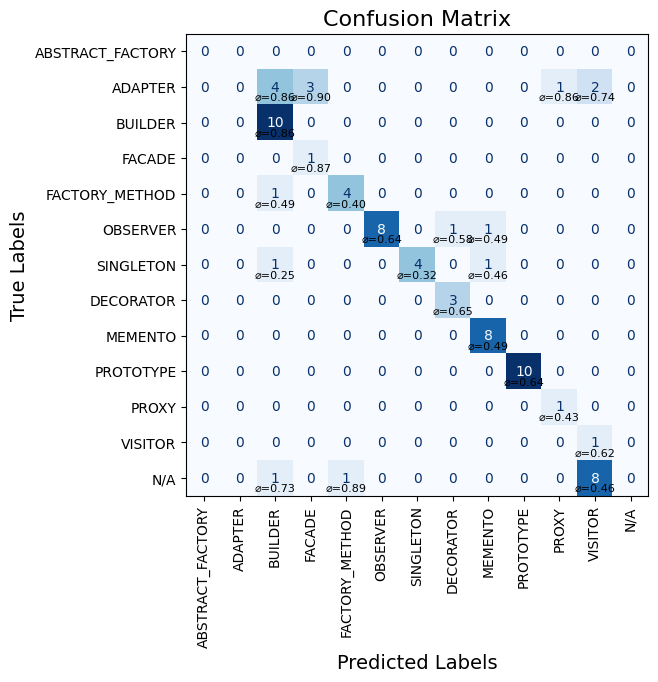

In [12]:
epm.compute_cm( true_labels, pred_labels, pred_scores, labels=pattern_types )

Should be: OBSERVER
VISITOR: 0.617
BUILDER: 0.616
PROXY: 0.615
PROTOTYPE: 0.615
FACTORY_METHOD: 0.546
FACADE: 0.545
OBSERVER: 0.542
MEMENTO: 0.541
SINGLETON: 0.447
DECORATOR: 0.443
ABSTRACT_FACTORY: 0.000585
{'source_type': 'OBSERVER', 'pattern_type': 'SINGLETON', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.3333333333333333}


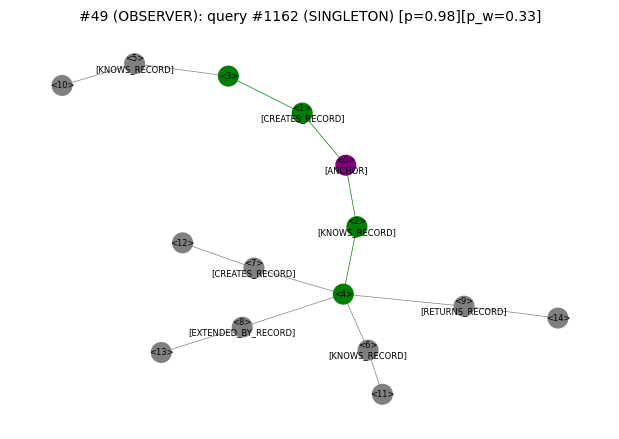

{'source_type': 'OBSERVER', 'pattern_type': 'FACTORY_METHOD', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5555555555555556}


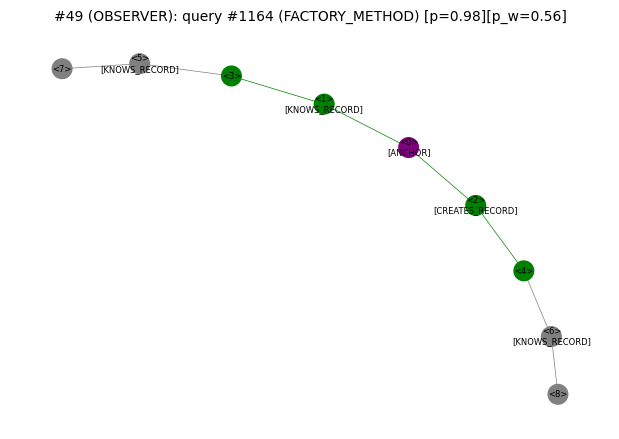

{'source_type': 'OBSERVER', 'pattern_type': 'ABSTRACT_FACTORY', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5555555555555556}


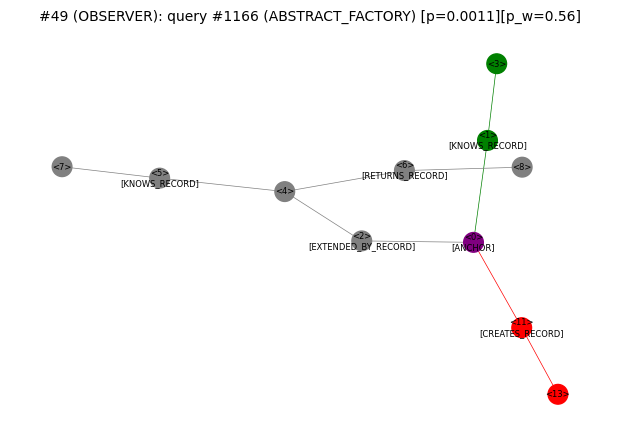

{'source_type': 'OBSERVER', 'pattern_type': 'FACADE', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5555555555555556}


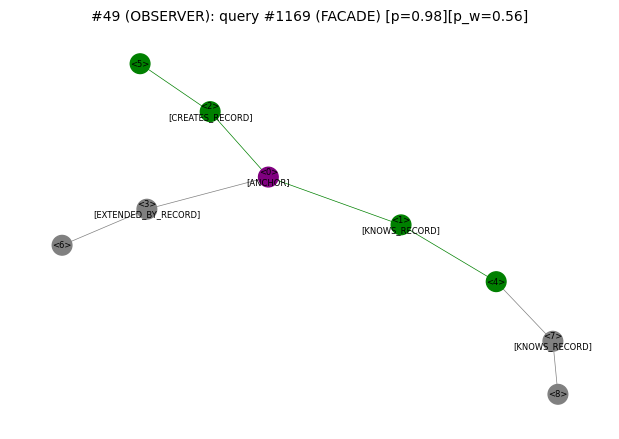

{'source_type': 'OBSERVER', 'pattern_type': 'OBSERVER', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5}


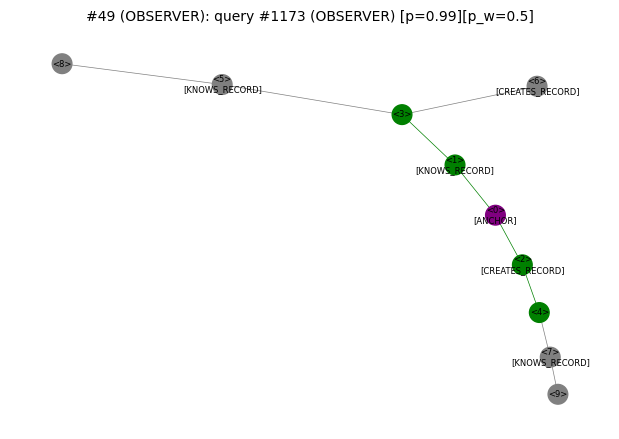

{'source_type': 'OBSERVER', 'pattern_type': 'PROXY', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5555555555555556}


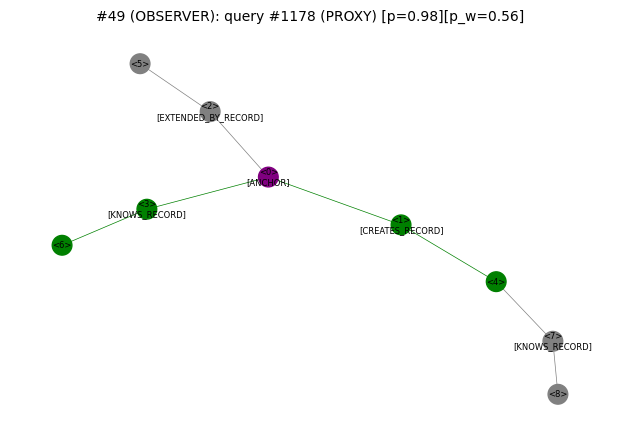

{'source_type': 'OBSERVER', 'pattern_type': 'VISITOR', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.625}


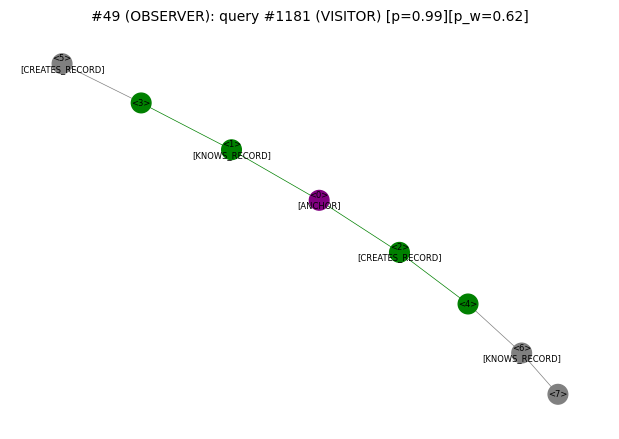

{'source_type': 'OBSERVER', 'pattern_type': 'BUILDER', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5555555555555556}


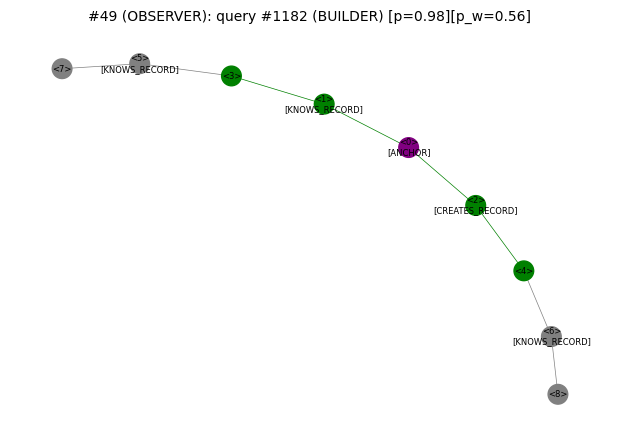

{'source_type': 'OBSERVER', 'pattern_type': 'PROTOTYPE', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5}


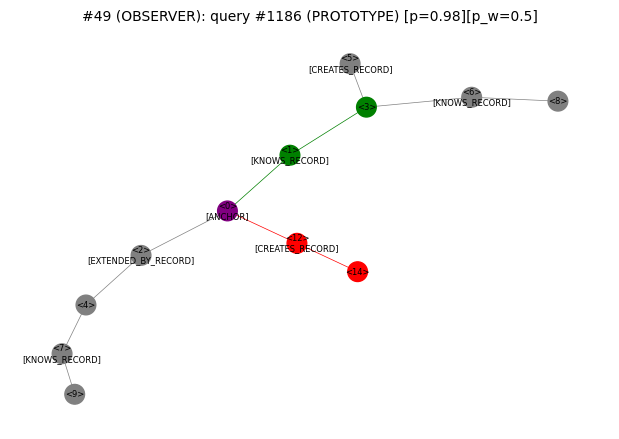

{'source_type': 'OBSERVER', 'pattern_type': 'DECORATOR', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.5}


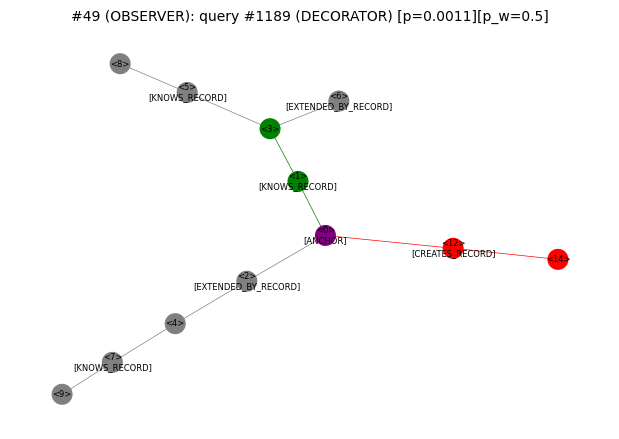

{'source_type': 'OBSERVER', 'pattern_type': 'MEMENTO', 'gidx': 49, 'record_scope': 'junit.awtui.TestRunner', 'record_dataset': 'p_mart-5_-_junit_v37', 'pred_w': 0.3125}


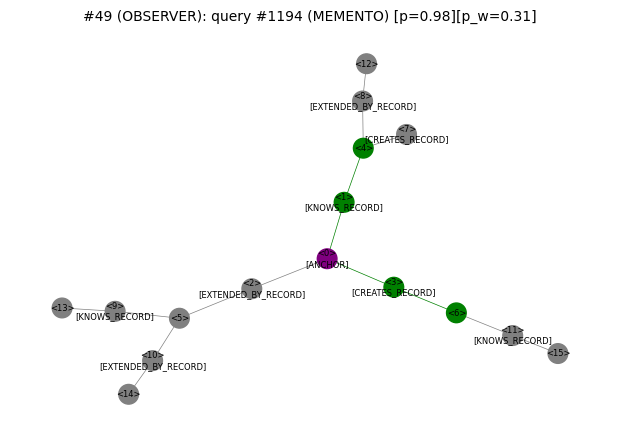

In [13]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = -1
source_iter = iter( groups_by_source )
for _ in range( 21 ):
    example_gidx = next( source_iter )
print( f"Should be: {dataset.get_source_patterns()[ example_gidx ]}" )
for pattern_type, score in misc_utils.sort_dict_by_value(
        source_preds[ example_gidx ], reverse=True ).items():
    print( f"{pattern_type}: {score:.3}" )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        pred = preds[ idx ]
        meta = metas[ idx ]
        print( meta )
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )